In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime as dt
from datetime import date
import tkinter.messagebox as mbox

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Environment settings: 
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.insert(1, 'C:/Users/Woon/Desktop/Columbia/Applied Analytics/Term3/Sentiment_SNP')

import helper_functions
from helper_functions import *

In [3]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

from transformers import pipeline

In [4]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Ticker

In [5]:
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import socket
import urllib

In [6]:
# text_input = input("Type in the Ticker: ")
# print("You entered:", text_input)

text_input = 'spy'

In [7]:
url = f"https://finviz.com/quote.ashx?t={text_input}&ty=c&ta=1&p=d"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    sentence2 = []

    for tag in soup.find_all('a'):

        sentence = tag.text.split(".")
        sentence2.append(sentence)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [8]:
df = pd.DataFrame(sentence2)

In [9]:
df['Headline'] = df[0]
df['Sentiment'] = -2
df = pd.DataFrame(list(zip(df['Headline'], df['Sentiment'])), columns=['Headline', 'Sentiment'])

In [10]:
i = []

for string in df['Headline']:
    i.append(count_words(string))

df['word_count'] = i

In [11]:
sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment'] = sentiment
df['Score'] = sentiment_score

In [12]:
df = df[df['word_count'] > 10]
df['Headline_Lower'] = df['Headline'].str.lower()

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

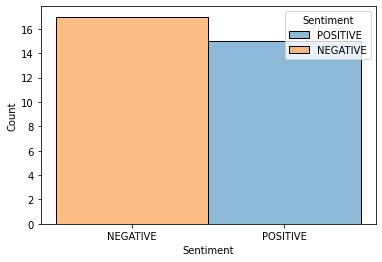

In [13]:
sns.histplot(x = 'Sentiment', data = df[df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

In [14]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in df["Headline_Lower"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [15]:
spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=1095), end=dt.date.today())
df=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [16]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15,6)
# sns.lineplot(x = 'Date', y = 'Close', data = df)
# plt.show()

In [17]:
# Load SPY price data
spy_data = df
spy_data = df[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=3)

# Make predictions for future dates
forecast = model.predict(future_dates)

22:11:46 - cmdstanpy - INFO - Chain [1] start processing
22:11:46 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
# fig.set_size_inches(15,6)
# plt.title('Forecasted Price')
# plt.xlabel('dt')
# plt.ylabel('Price')
# plt.show()

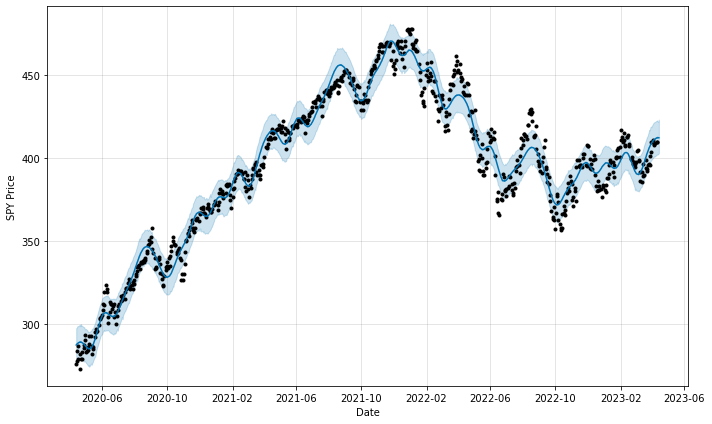

(19452.0, 19462.0)

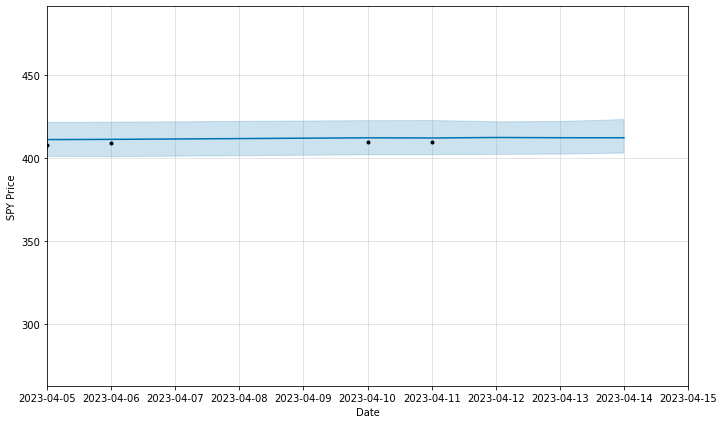

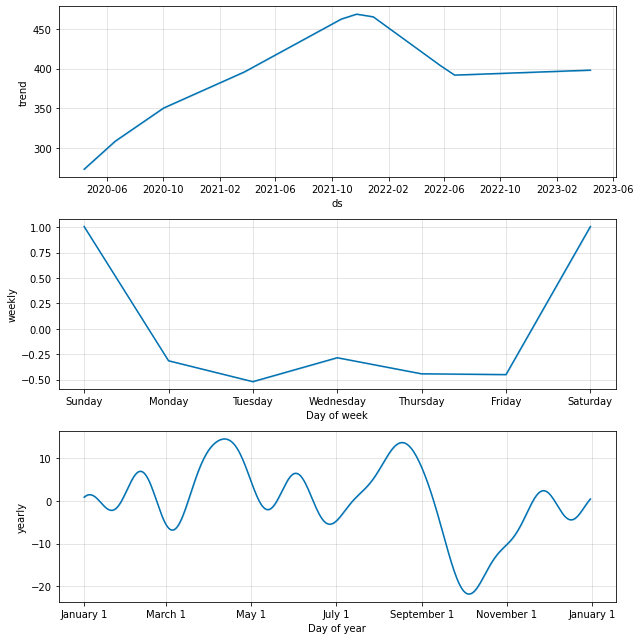

In [19]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.date.today() - dt.timedelta(days=7), dt.date.today() + dt.timedelta(days=3))

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()

In [20]:
spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=7), end=dt.date.today(), interval='1m')
df1=spy_ohlc_df.reset_index()

# spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=7), end=dt.date.today())
# df1=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [21]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15,6)
# sns.lineplot(x = 'Datetime', y = 'Close', data = df1)
# plt.show()

In [22]:
# Load SPY price data
spy_data = df1
spy_data = df1[['Datetime', 'Close']]
#spy_data = df1[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=2880, freq='T')

# Make predictions for future dates
forecast = model.predict(future_dates)


22:11:50 - cmdstanpy - INFO - Chain [1] start processing
22:11:51 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
# fig.set_size_inches(15,6)
# plt.title('Forecasted Price')
# plt.xlabel('dt')
# plt.ylabel('Price')
# plt.show()

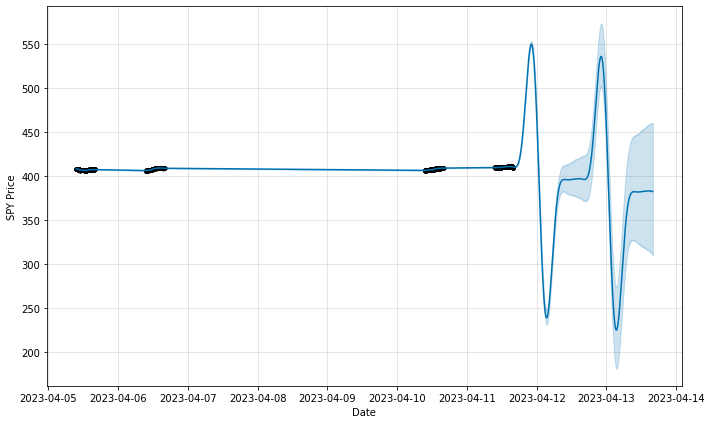

(19458.0, 19460.0)

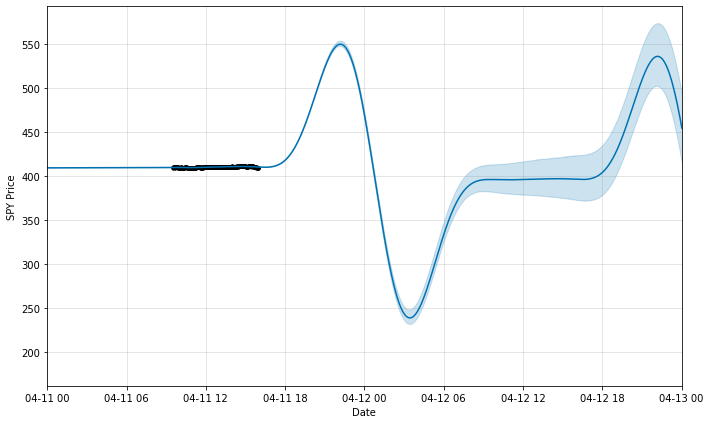

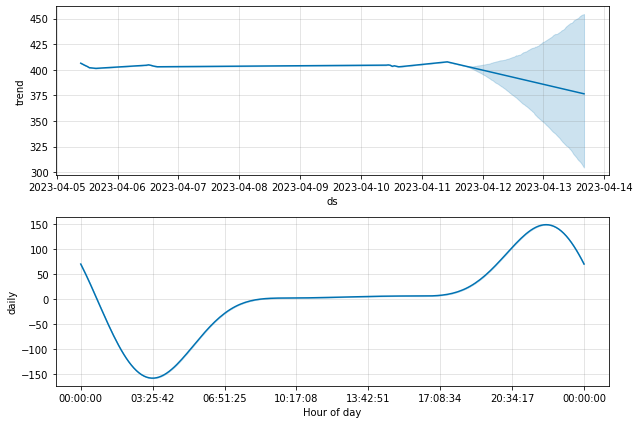

In [24]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.date.today() - dt.timedelta(days=1), dt.date.today() + dt.timedelta(minutes=1440))

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()